In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
%matplotlib inline
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
import ipywidgets as widgets
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display, clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

## Dataset


In [3]:
# load datasets in colab
#books = pd.read_csv('/content/drive/MyDrive/colab_notebooks/data/Books.csv')
#ratings = pd.read_csv('/content/drive/MyDrive/colab_notebooks/data/Ratings.csv')
#users = pd.read_csv('/content/drive/MyDrive/colab_notebooks/data/Users.csv')

In [78]:
# load datasets local
books = pd.read_csv('./data/Books.csv')
ratings = pd.read_csv('./data/Ratings.csv')
users = pd.read_csv('./data/Users.csv')

/home/guinto/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [79]:
print(books.shape)
books.rename(columns = {'ISBN':'isbn', 'Book-Title':'book_title'}, inplace=True)

print(books.info())

(271360, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271360 non-null  object
 1   book_title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None


In [80]:
print(ratings.shape)
ratings.columns = ['user_id','isbn','rating']

print(ratings.info())

(1149780, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  int64 
 1   isbn     1149780 non-null  object
 2   rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


In [81]:
print(users.shape)
users.columns = ['user_id','location', 'age']
print(users.info())

(278858, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None


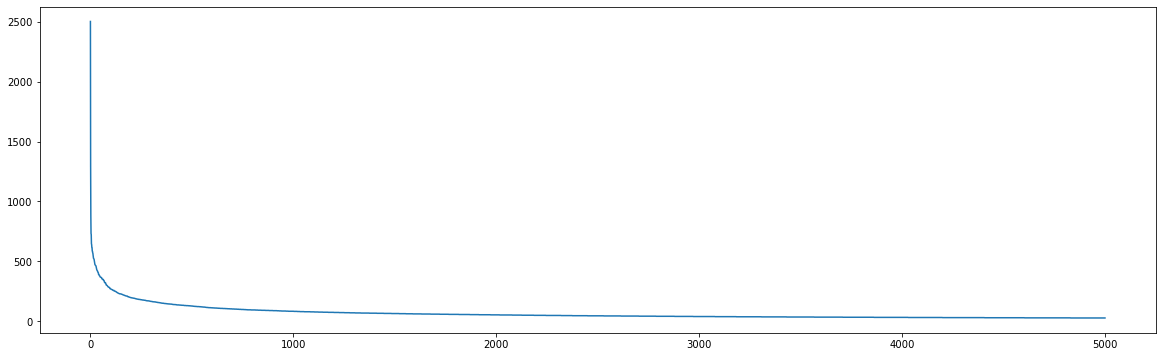

In [82]:
num_book_ratings = ratings.isbn.value_counts().values

plt.figure(figsize=(20,6))
plt.plot(np.arange(0,5000), num_book_ratings[:5000])

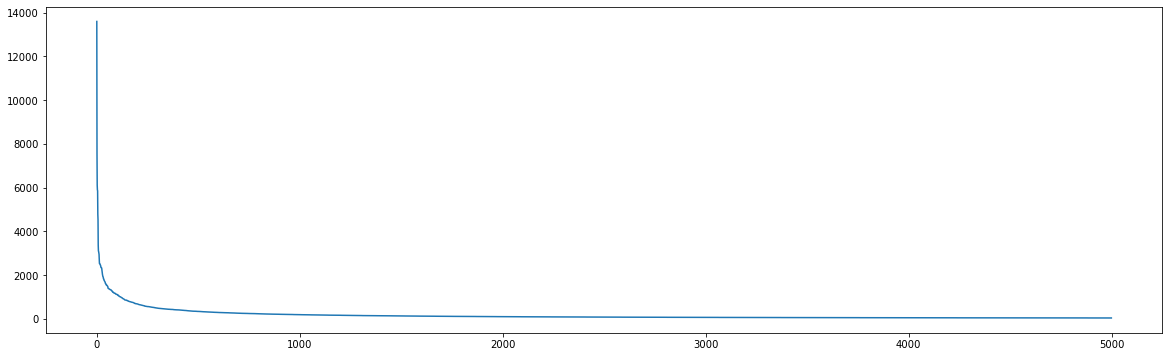

In [83]:
num_ratings = ratings.user_id.value_counts().values

plt.figure(figsize=(20,6))
plt.plot(np.arange(0,5000), num_ratings[:5000])

### Data cleaning

In [97]:
books['book_title'] = books['book_title'].str.lower()

In [98]:
# book titles with multiple ISBN
unique_book_titles = books[['isbn','book_title']].groupby('book_title').count()
unique_book_titles.sort_values(by='isbn', ascending=False)

,isbn
book_title,
selected poems,28
little women,26
wuthering heights,22
dracula,21
the secret garden,21
...,...
histoire du journalisme et des journalistes en france: du xviie siã¨cle ã nos jours (que sais-je?),1
histoire du juif errant,1
histoire du quebec contemporain,1


In [85]:
# ISBN with multiple book titles
unique_isbn = books[['isbn','book_title']].groupby('isbn').count()
unique_isbn.sort_values(by='book_title', ascending=False)

,book_title
isbn,
0000913154,1
0812515560,1
0812514440,1
0812514459,1
0812514475,1
...,...
0441505325,1
0441510108,1
0441510124,1


In [86]:
# isbn in ratings table without info in books table
books_isbn_set = set(books['isbn'].unique())
ratings_isbn_set = set(ratings['isbn'].unique())

isbn_no_info = ratings_isbn_set.difference(books_isbn_set)

len(isbn_no_info)

70405

Drop entries in ratings table that do not have a match in the books table. 

In [102]:
ratings_w_info = ratings[~ratings.isbn.isin(isbn_no_info)]
ratings_w_info = ratings_w_info.reset_index(drop=True)

In [103]:
# add book title to ratings tables
ratings_w_info = ratings_w_info.merge(books[['isbn','book_title']], on='isbn')

In [105]:
# isbn in ratings table without info in books table
users_userid_set = set(users['user_id'].unique())
ratings_userid_set = set(ratings['user_id'].unique())

user_no_info = ratings_userid_set.difference(users_userid_set)

len(user_no_info)

0

Drop entries in ratings table that do not have a match in the books table. 

In [87]:
len(books_isbn_set.difference(ratings_isbn_set))

1209

In [10]:
import recmetrics

## Problem

* Give top N book recommendations to a particular user. 

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

We assess the quality of the recommendations 

## Model 1 - Collaborative filtering with filtered data as features.

Following [this](https://www.analyticsvidhya.com/blog/2021/06/build-book-recommendation-system-unsupervised-learning-project/) guide, we start by training a nearest neighbor model with a sparse matrix of user-book ratings. 

In [106]:
print("Number of unique user_id in ratings table: ", ratings.user_id.nunique())
print("Number of users with more than 5 ratings: ",(ratings.user_id.value_counts() >= 5).sum())
print("Number of users with more than 10 ratings: ",(ratings.user_id.value_counts() >= 10).sum())
print("Number of users with more than 20 ratings: ",(ratings.user_id.value_counts() >= 20).sum())

Number of unique user_id in ratings table:  105283
Number of users with more than 5 ratings:  22816
Number of users with more than 10 ratings:  13097
Number of users with more than 20 ratings:  7369


In [108]:
print("Number of unique isbn in ratings table: ", ratings.isbn.nunique())
print("Number of books with more than 5 ratings: ",(ratings.isbn.value_counts() >= 5).sum())
print("Number of books with more than 10 ratings: ",(ratings.isbn.value_counts() >= 10).sum())
print("Number of books with more than 20 ratings: ",(ratings.isbn.value_counts() >= 20).sum())
print("Number of books with more than 30 ratings: ",(ratings.isbn.value_counts() >= 30).sum())

Number of unique isbn in ratings table:  340556
Number of books with more than 5 ratings:  43765
Number of books with more than 10 ratings:  18319
Number of books with more than 20 ratings:  7490
Number of books with more than 30 ratings:  4405


In [116]:
min_num_ratings = 25

book_filter = pd.DataFrame(ratings_w_info.isbn.value_counts())
book_filter = book_filter[book_filter.isbn >= min_num_ratings].index
ratings_filtered = ratings_w_info[ratings_w_info.isbn.isin(book_filter)].reset_index(drop=True)

In [117]:
ratings_mtx = ratings_filtered.pivot_table(columns='user_id', index='book_title', values='rating')

In [118]:
ratings_mtx.fillna(0, inplace=True)

In [119]:
ratings_mtx_sparse = csr_matrix(ratings_mtx)

we now have a sparse user-item rating matrix.

In [120]:
books.set_index('book_title', inplace=True)

Nearest neighbour model training

In [126]:
from sklearn.neighbors import NearestNeighbors

mdl = NearestNeighbors(algorithm='brute', n_neighbors=5)
mdl.fit(ratings_mtx)

NearestNeighbors(algorithm='brute')

In [127]:
def get_topK(title):
    # get top K similar books
    distances, suggestions = mdl.kneighbors(ratings_mtx.loc[title].values.reshape(1, -1))
    

    recommended_titles = books.loc[ratings_mtx.index[suggestions[0]]]
    recommended_titles = recommended_titles[recommended_titles.index != title]
    
    # return title of suggested books
    return recommended_titles

## DEMO UI

In [128]:
# functions
f = open("blank.png", "rb")
blank_image = f.read()

def get_img_from_url(title):
    # get image URL
    img_loc = books.loc[title]['Image-URL-M']
    
    # handle duplicates
    if len(img_loc) > 1:
        img_loc = img_loc[0]
    
    try:
        # get image from url
        response = requests.get(img_loc, timeout=0.1)
        return response.content
    except:
        # if url fails, return blank image
        return blank_image
    
def make_reco_image(titles):
    fig, axs = plt.subplots(ncols=3, figsize=(15,6))
    
    for title, ax in zip(titles, axs):

        ax.set_xticks([])
        ax.set_yticks([])
        
        img = Image.open(BytesIO(get_img_from_url(title)))
        ax.imshow(img)
        ax.set_title(title, size=12)
    
    fig.set_facecolor('#FFFFFF')
    return fig, axs

In [129]:
# UI
included_books_list = ratings_mtx.index.unique()

book_selection = widgets.Dropdown(
    options=included_books_list,
    value=included_books_list[0],
    description='Title:',
)
out = widgets.Output()
display(book_selection, out)

def on_value_change(change):

    with out:
        out.clear_output()
        reco_list = list(get_topK(change['new']).index.unique()[:3])
        
        make_reco_image(reco_list)
        
        show_inline_matplotlib_plots()
        
book_selection.observe(on_value_change, names='value')

Dropdown(description='Title:', options=("'salem's lot", '10 lb. penalty', '14,000 things to be happy about', '…

Output()